https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators  
For what purpose was the dataset created?

* To better understand the relationship between  lifestyle and diabetes in the US

Who funded the creation of the dataset?

* The CDC

What do the instances in this dataset represent?

* Each row represents a person participating in this study.

Are there recommended data splits?

* Cross validation or a fixed train-test split could be used.

Does the dataset contain data that might be considered sensitive in any way?

- Gender
- Income
- Education level

Was there any data preprocessing performed?

* Bucketing of age

Additional Information

* Dataset link: https://www.cdc.gov/brfss/annual_data/annual_2014.html

Has Missing Values?

* No  

diabetes _ binary _ health _ indicators _ BRFSS2015.csv is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015. The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes. This dataset has 21 feature variables and is not balanced.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing

import shap

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import F1Score, Recall, AUC

import statsmodels.formula.api as smf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def scores(_y_val, _y_pred):
    tn, fp, fn, tp = confusion_matrix(_y_val, _y_pred).ravel()
    specificity = tn / (tn+fp)
    print("Accuracy: ", round(accuracy_score(_y_val, _y_pred), 2)) 
    print("Specificity: ", round(tn / (tn+fp), 2)) 
    print("Recall: ", round(recall_score(_y_val, _y_pred), 2)) 
    print("F1 Score:", round(f1_score(_y_val, _y_pred), 2))

In [3]:
callback_a = ModelCheckpoint(filepath = 'my_best_model.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1)

In [4]:
def train_model(model, X, y, X_test, y_test, callback=[callback_a, callback_b]):
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall', 'accuracy', 'AUC'])
	return model.fit(X, y, validation_data=(X_test, y_test), epochs=500, callbacks=callback, verbose=0)

In [5]:
def evaluate_model(model, history, X, y):
    y_pred_k = model.predict(X)
    y_pred_kb = (y_pred_k >= 0.5)*1
    
    scores(y, y_pred_kb)
        
    pd.DataFrame(history.history).iloc[:, [2,4,5,6,7]].plot(figsize=(8,5))
    plt.ylim(-0.05,1.05)
    plt.show()
    
    
    x = np.arange(0,1.01,.01)
    recall = [recall_score(y, (y_pred_k >= i)*1) for i in x]
    accuracy = [accuracy_score(y, (y_pred_k >= i)*1) for i in x]
    sns.scatterplot(x=x, y=recall, label="recall", s=20)
    sns.scatterplot(x=x, y=accuracy, label="accuracy", s=20)
    plt.title("Recall and Accuracy Againt Probability Cut-Off")
    plt.ylabel("Recall or Accuracy")
    plt.xlabel("Cut-Off Value")
    plt.legend()
    plt.show()
    
    
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred_kb)
    vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    vis.plot()
    plt.show()

## Phase 1: Data Analysis and Preparation  

* Once you have found a dataset you like
* load the data in a Python Notebook
* normalize your data. CANNOT DO THIS UNTIL DATA IS SPLIT.
* In your report’s introduction section please discuss:
    - why you chose to work on this project
    - explain the problem you plan to solve.
    - mention the source of your dataset.

        
* visualize/plot the distributions of each input feature and discuss the range of the values (min, max, mean, median, etc.). For example, plot histograms showing distribution of each input features. Selected visualizations should be included in the report.

* Discuss the distribution of the output labels.
* Check if the data is imbalanced by calculating what percentage of the output labels are 0 and what percentage are 1. If your dataset is heavily imbalanced (for example, 1% vs 99%) it may be a better idea to choose a different dataset. 

In [6]:
df = pd.read_csv("diabetes_pima.csv")

In [7]:
# Bootstrap sampling in order to meet project requirement 
extras = df.sample(n=300, replace=True)
df=pd.concat([df, extras], axis=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, 0 to 636
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               1068 non-null   int64  
 1   Glucose                   1068 non-null   int64  
 2   BloodPressure             1068 non-null   int64  
 3   SkinThickness             1068 non-null   int64  
 4   Insulin                   1068 non-null   int64  
 5   BMI                       1068 non-null   float64
 6   DiabetesPedigreeFunction  1068 non-null   float64
 7   Age                       1068 non-null   int64  
 8   Outcome                   1068 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 83.4 KB


In [9]:
df.head(3).transpose()

,0,1,2
Pregnancies,6.000,1.000,8.000
Glucose,148.000,85.000,183.000
BloodPressure,72.000,66.000,64.000
SkinThickness,35.000,29.000,0.000
Insulin,0.000,0.000,0.000
BMI,33.600,26.600,23.300
DiabetesPedigreeFunction,0.627,0.351,0.672
Age,50.000,31.000,32.000
Outcome,1.000,0.000,1.000


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,1068.0,3.911049,3.428825,0.000,1.00000,3.0000,6.00000,17.00
Glucose,1068.0,120.922285,32.142673,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,1068.0,69.119850,19.777551,0.000,64.00000,72.0000,80.00000,122.00
SkinThickness,1068.0,20.009363,15.954948,0.000,0.00000,22.0000,32.00000,99.00
Insulin,1068.0,77.311798,113.641997,0.000,0.00000,0.0000,125.00000,846.00
BMI,1068.0,31.968258,8.083959,0.000,27.30000,32.0000,36.80000,67.10
DiabetesPedigreeFunction,1068.0,0.474938,0.329325,0.078,0.24575,0.3815,0.63025,2.42
Age,1068.0,33.254682,11.627083,21.000,24.00000,29.0000,41.00000,81.00
Outcome,1068.0,0.354869,0.478698,0.000,0.00000,0.0000,1.00000,1.00


In [11]:
df.Outcome.value_counts(normalize=True).round(2)

Outcome
0    0.65
1    0.35
Name: proportion, dtype: float64

In [12]:
df.Outcome.value_counts()

Outcome
0    689
1    379
Name: count, dtype: int64

In [13]:
numeric_cols = list(df.drop(labels=["Outcome"], axis=1).columns)
numeric_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

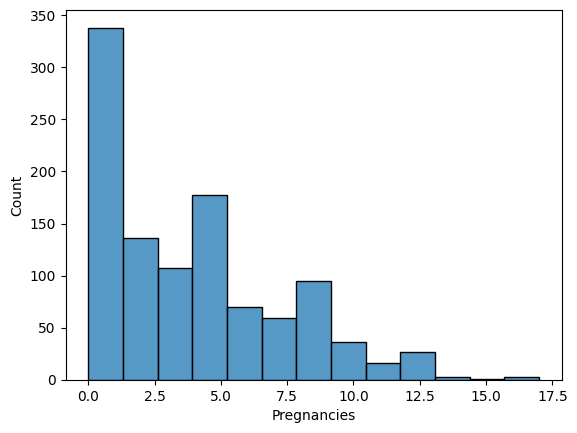

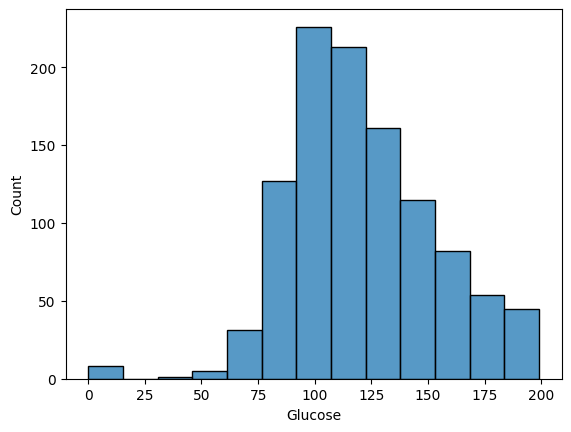

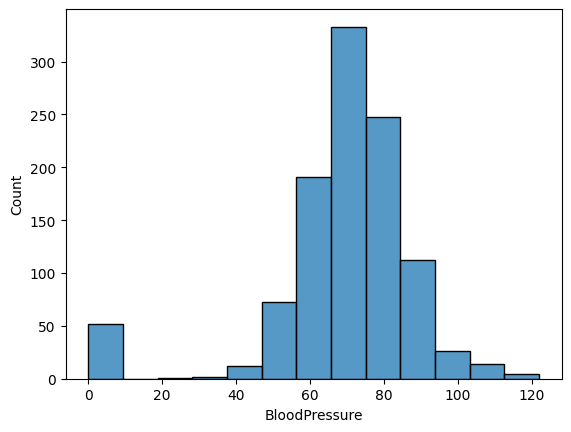

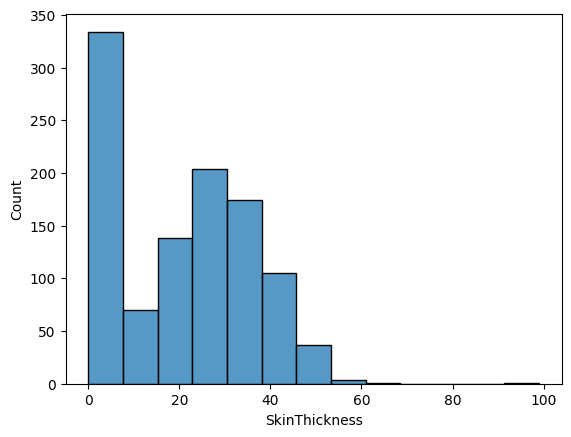

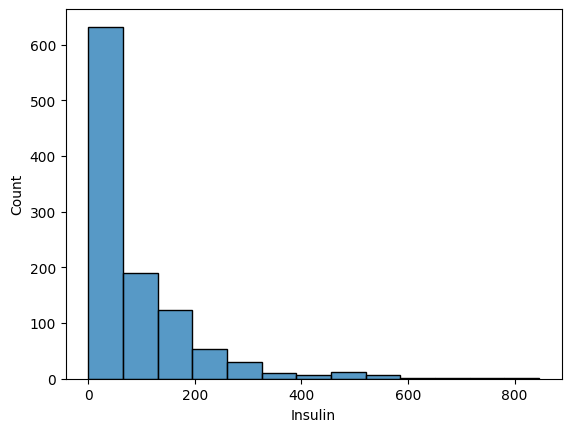

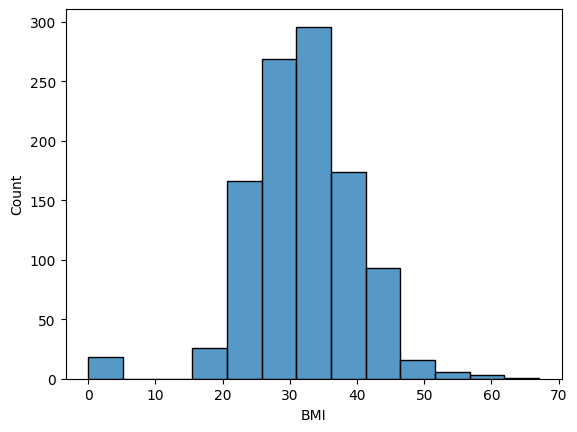

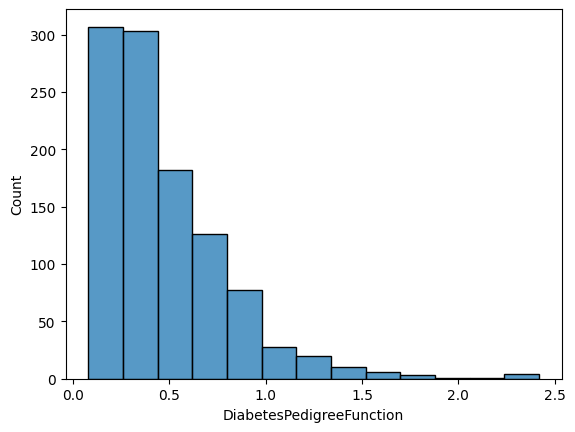

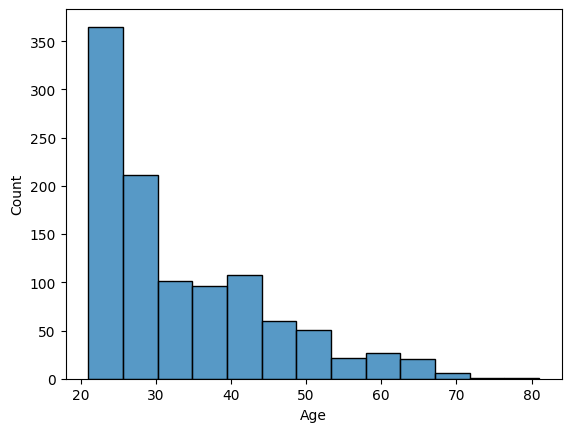

In [14]:
for column in numeric_cols:
    sns.histplot(data = df, x=column, bins=13)
    plt.show()


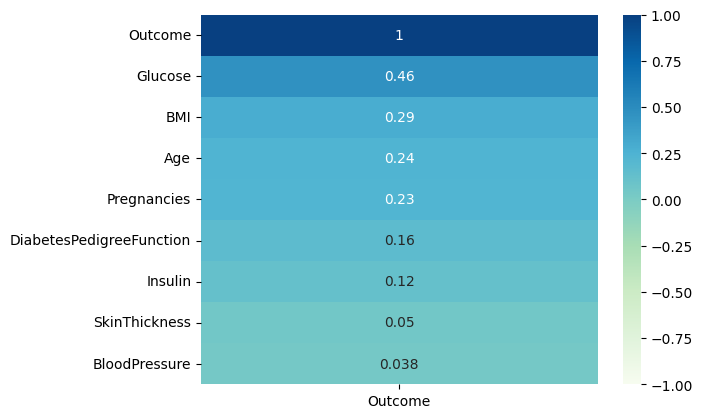

In [15]:
# Plotting the heatmap to check the correlation between the Target Label and other features
sns.heatmap(df.corr()[['Outcome']].sort_values(by='Outcome', ascending=False), vmin=-1, vmax=1, annot=True, cmap='GnBu')
plt.show()

## Phase 2: Build a Model to Overfit the Entire Dataset

The main goal in this phase is to experiment and find what network size is needed to ‘overfit’ the entire dataset at your hand.  

* Do not split your data into training and validation.  

* The place to start is to use ‘logistic regression’ model and train for as many epochs as needed to obtain as high accuracy as possible. 
After training hundreds of epochs if you observe that the accuracy is not increasing then it implies that the number of neurons in your model (only one) may not be sufficient for overfitting.  

* The next step is to grow your model into a multi-layer model and add a few neurons (say only 2) in the input layer. This way your model will have ‘2 + 1 = 3’ neurons in total.
* If your accuracy still does not each a 100% or close to 100% you can continue to increase the number of layers and number of neurons.
* Once you have obtained 100% accuracy (or around 100%) your experiments for this phase are complete.

The results of this experiment also inform us that our final model (in subsequent phases) should be smaller than this model. 

### Standardize Numeric Data and Prepare for Use in ML Models

In [16]:
def data_norms(data):
    mean_ = data.mean()
    std_ = data.std()
    return (data - mean_)/std_

In [17]:
df_2 = df.copy().sample(frac=1)

In [18]:
for column in numeric_cols:
    df_2[column] = data_norms(df_2[column])

In [19]:
df_2[numeric_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,1068.0,-3.326511e-18,1.0,-1.140638,-0.848993,-0.265703,0.609232,3.817328
Glucose,1068.0,-1.297339e-16,1.0,-3.762048,-0.682031,-0.122027,0.601310,2.429098
BloodPressure,1068.0,3.409674e-16,1.0,-3.494864,-0.258872,0.145627,0.550126,2.673746
SkinThickness,1068.0,1.663255e-17,1.0,-1.254116,-1.254116,0.124766,0.751531,4.950855
Insulin,1068.0,1.663255e-17,1.0,-0.680310,-0.680310,-0.680310,0.419635,6.764121
BMI,1068.0,2.128967e-16,1.0,-3.954530,-0.577472,0.003926,0.597695,4.345858
DiabetesPedigreeFunction,1068.0,-4.657115e-17,1.0,-1.205309,-0.695934,-0.283727,0.471607,5.906210
Age,1068.0,-1.330604e-17,1.0,-1.053977,-0.795959,-0.365929,0.666145,4.106388


In [20]:
X = df_2.drop(axis=1, labels='Outcome')
y = df_2['Outcome']

### Build increasingly more complex models

In [21]:
model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 9 (36.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 211: early stopping


34/34 [==============================] - 0s 339us/step
Accuracy:  0.78
Specificity:  0.89
Recall:  0.6
F1 Score: 0.66


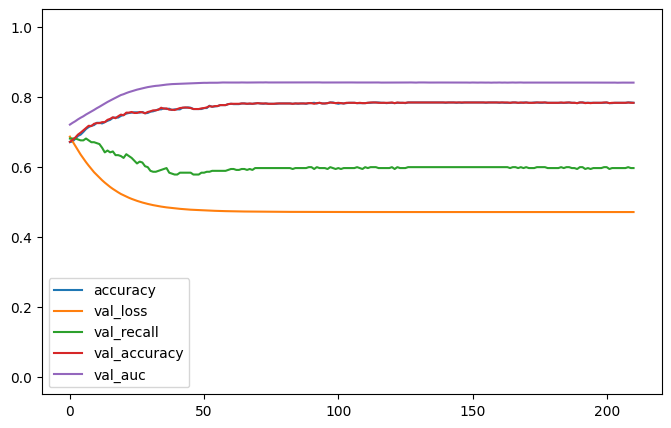

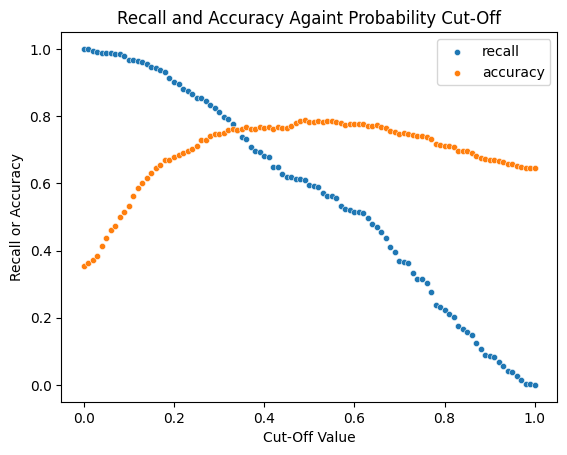

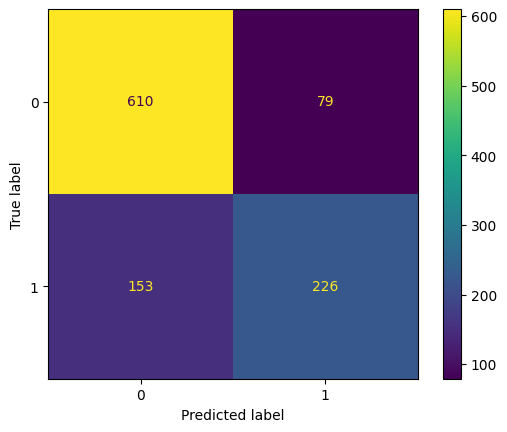

In [22]:
evaluate_model(model, history, X, y)

In [23]:
model = Sequential()
model.add(Dense(2, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


34/34 [==============================] - 0s 369us/step
Accuracy:  0.78
Specificity:  0.9
Recall:  0.57
F1 Score: 0.65


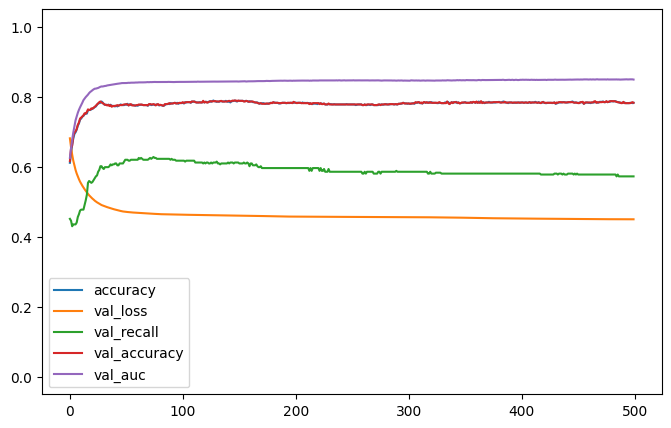

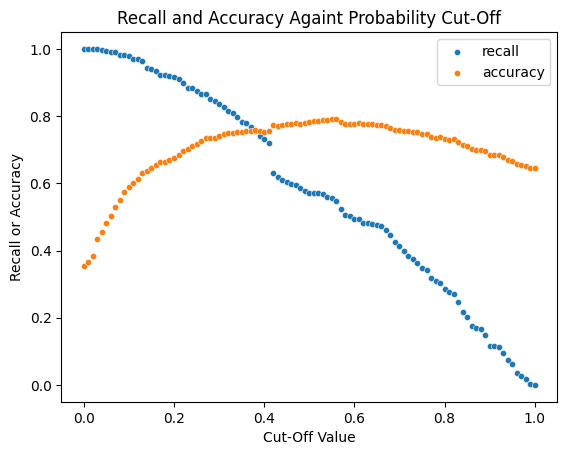

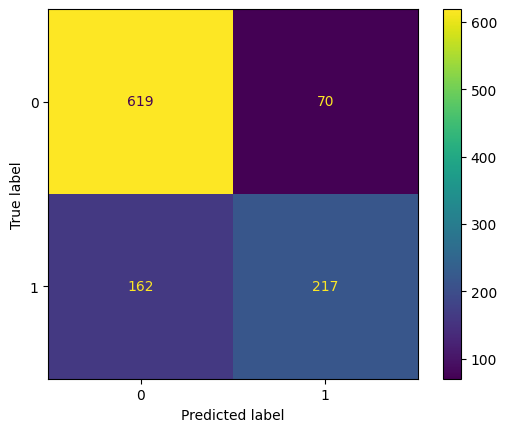

In [24]:
evaluate_model(model, history, X, y)

In [25]:
model = Sequential()
model.add(Dense(4, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


34/34 [==============================] - 0s 690us/step
Accuracy:  0.79
Specificity:  0.87
Recall:  0.64
F1 Score: 0.68


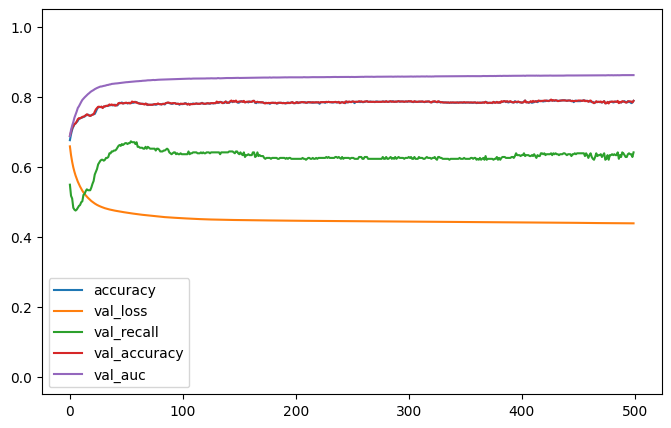

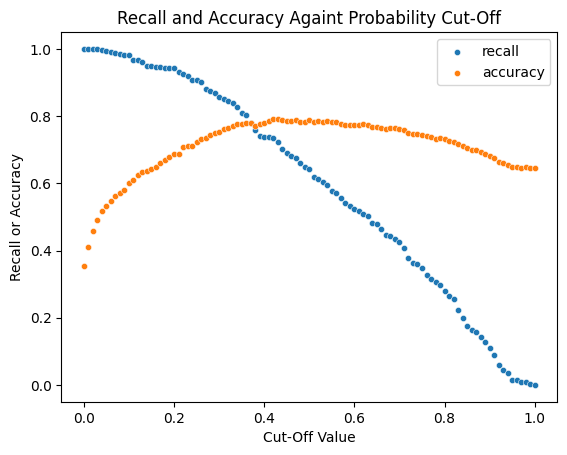

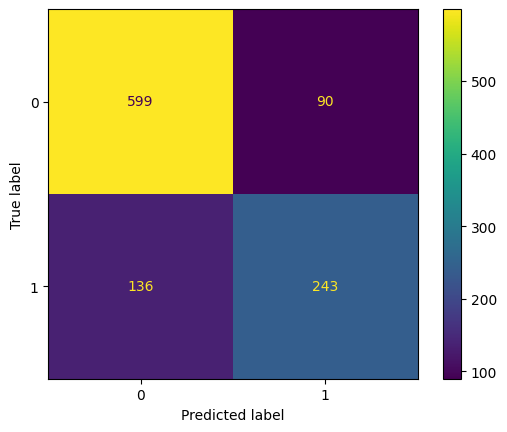

In [26]:
evaluate_model(model, history, X, y)

In [27]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


34/34 [==============================] - 0s 438us/step
Accuracy:  0.81
Specificity:  0.89
Recall:  0.66
F1 Score: 0.71


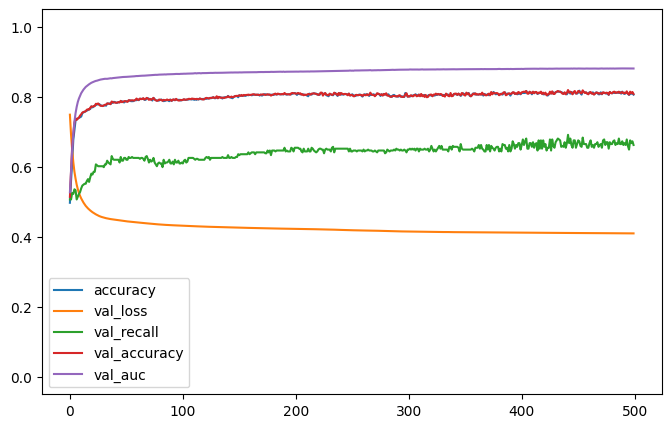

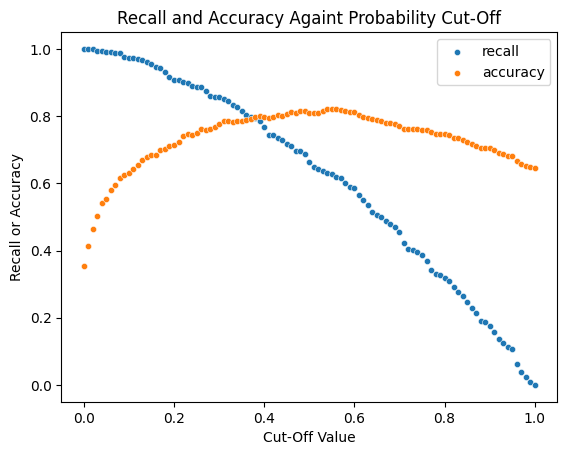

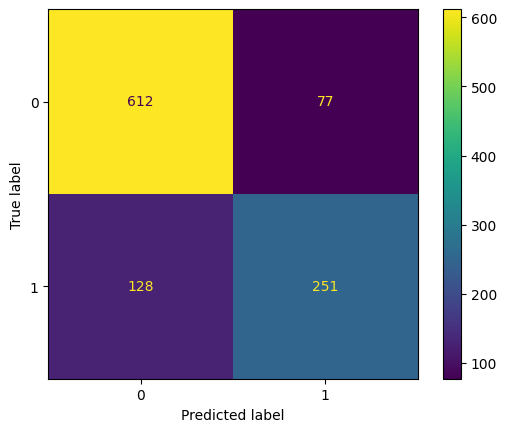

In [28]:
evaluate_model(model, history, X, y)

In [29]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dense_8 (Dense)             (None, 6)                 54        
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 133 (532.00 Byte)
Trainable params: 133 (532.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


34/34 [==============================] - 0s 367us/step
Accuracy:  0.85
Specificity:  0.9
Recall:  0.77
F1 Score: 0.79


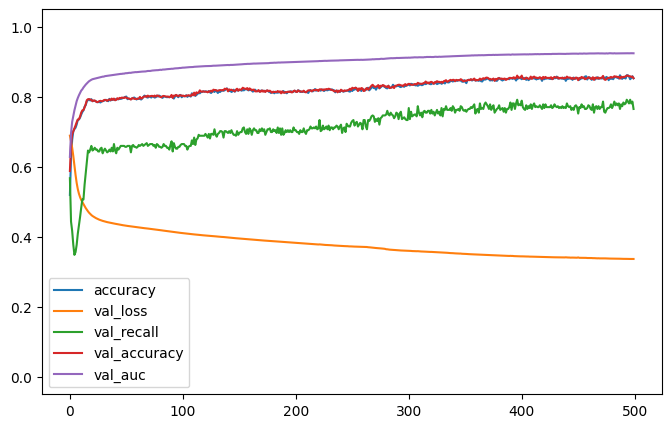

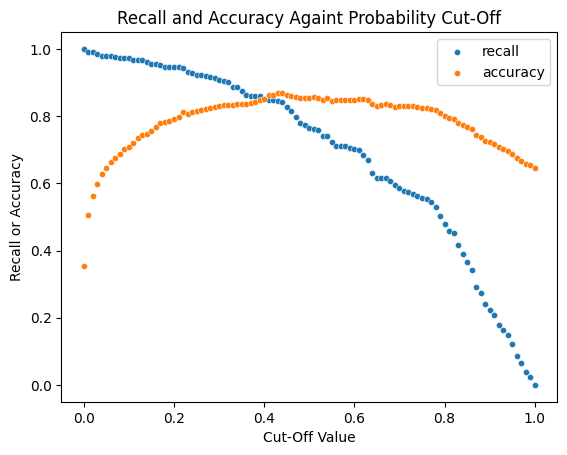

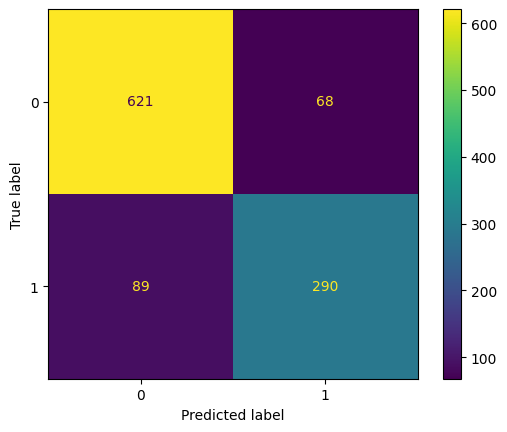

In [30]:
evaluate_model(model, history, X, y)

In [31]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['Recall', 'accuracy', 'AUC'])
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dense_11 (Dense)            (None, 8)                 72        
                                                                 
 dense_12 (Dense)            (None, 8)                 72        
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


34/34 [==============================] - 0s 430us/step
Accuracy:  0.87
Specificity:  0.9
Recall:  0.83
F1 Score: 0.82


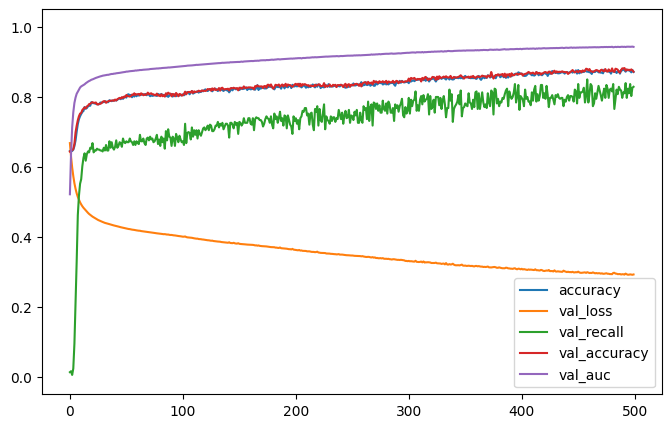

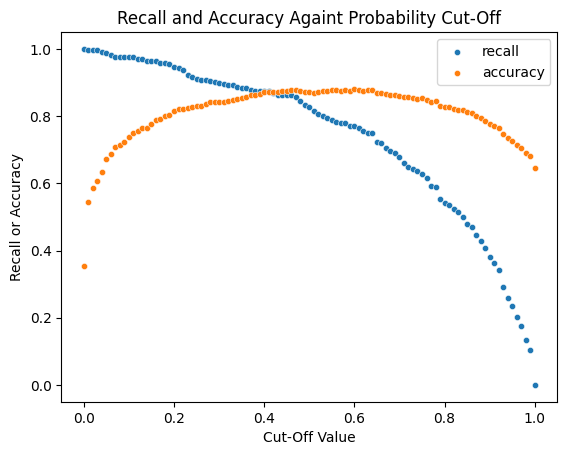

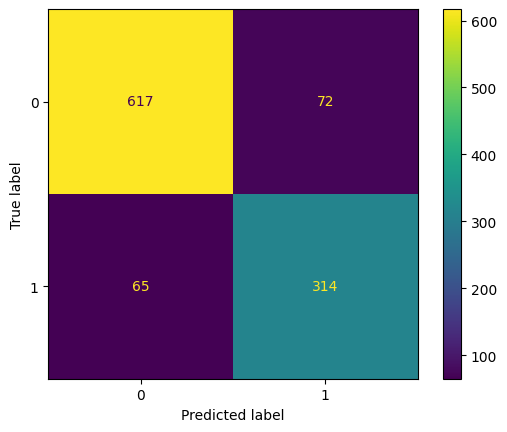

In [32]:
evaluate_model(model, history, X, y)

In [33]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                144       
                                                                 
 dense_15 (Dense)            (None, 8)                 136       
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


34/34 [==============================] - 0s 386us/step
Accuracy:  0.88
Specificity:  0.93
Recall:  0.77
F1 Score: 0.82


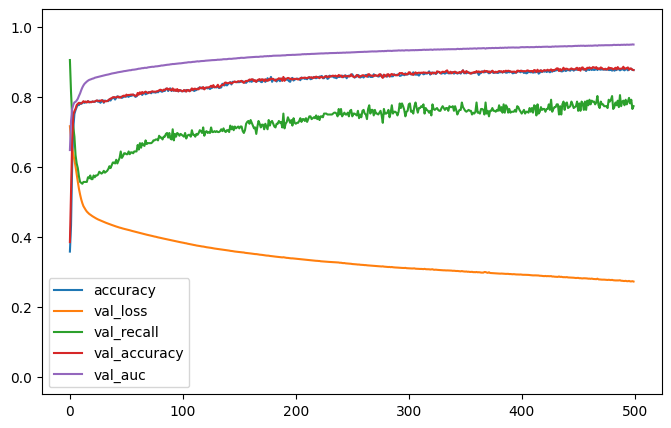

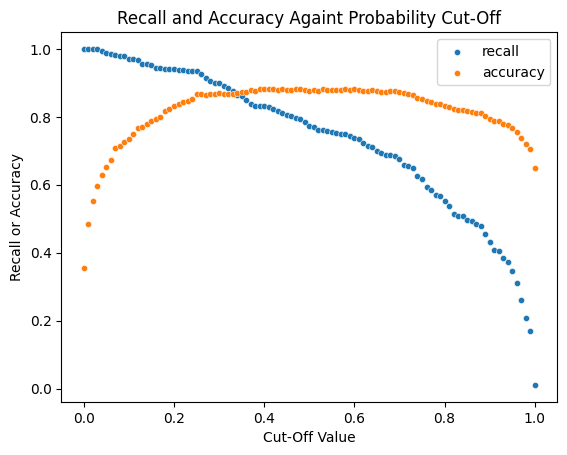

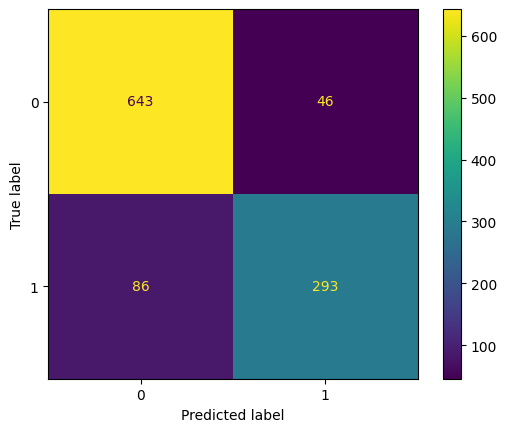

In [34]:
evaluate_model(model, history, X, y)

In [35]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 16)                144       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 8)                 72        
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


34/34 [==============================] - 0s 399us/step
Accuracy:  0.96
Specificity:  0.98
Recall:  0.92
F1 Score: 0.94


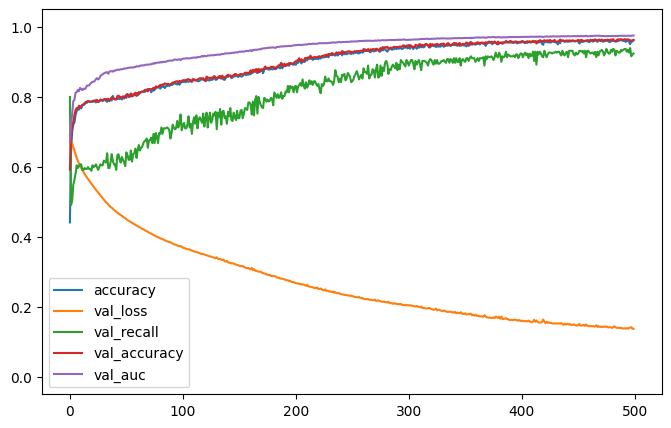

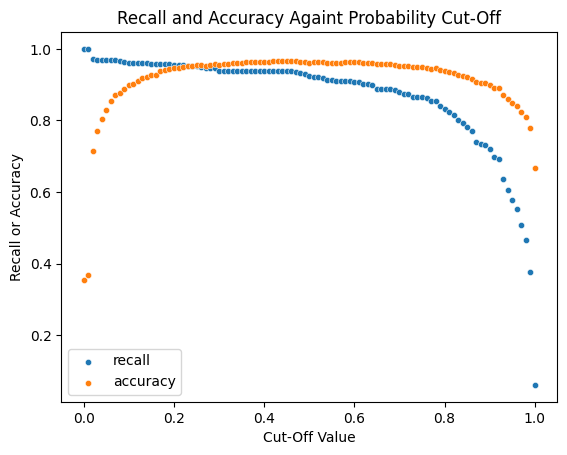

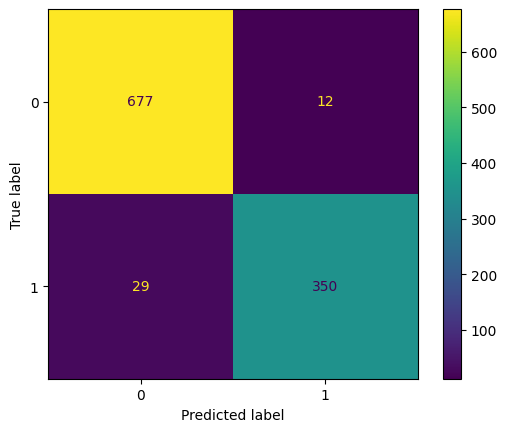

In [36]:
evaluate_model(model, history, X, y)

In [37]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 16)                144       
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 8)                 72        
                                                                 
 dense_24 (Dense)            (None, 8)                 72        
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 433 (1.69 KB)
Trainable params: 433 (1.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


34/34 [==============================] - 0s 465us/step
Accuracy:  0.96
Specificity:  0.94
Recall:  0.99
F1 Score: 0.95


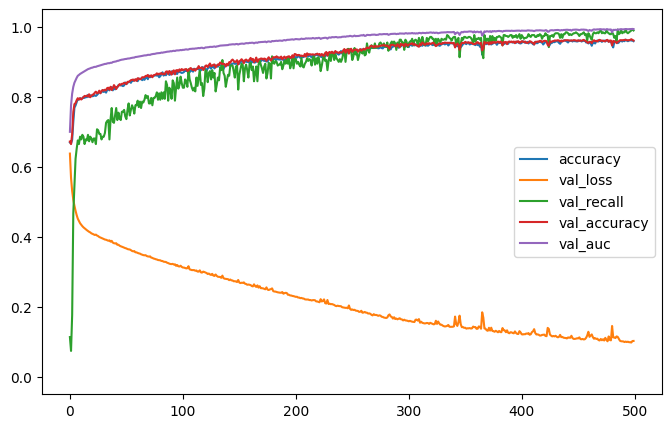

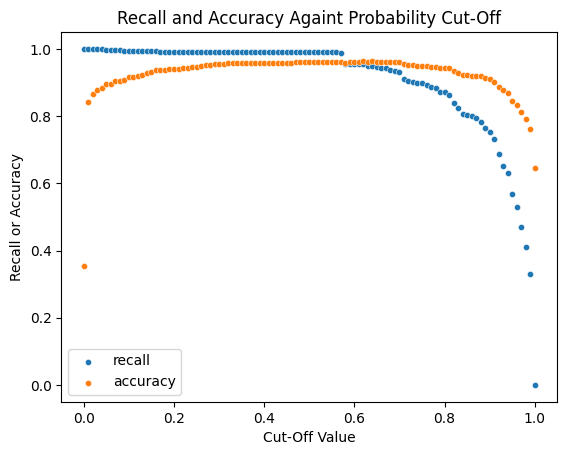

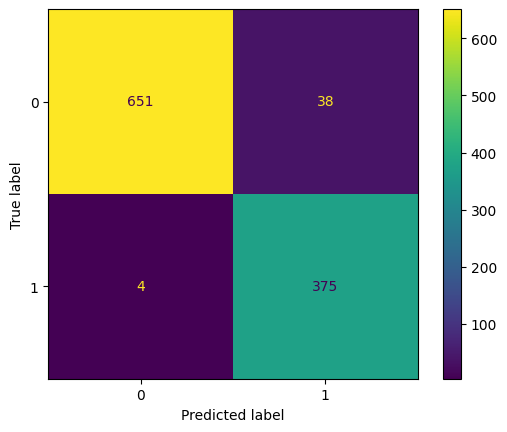

In [38]:
evaluate_model(model, history, X, y)

In [39]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 16)                144       
                                                                 
 dense_27 (Dense)            (None, 8)                 136       
                                                                 
 dense_28 (Dense)            (None, 8)                 72        
                                                                 
 dense_29 (Dense)            (None, 8)                 72        
                                                                 
 dense_30 (Dense)            (None, 8)                 72        
                                                                 
 dense_31 (Dense)            (None, 8)                 72        
                                                                 
 dense_32 (Dense)            (None, 1)                

34/34 [==============================] - 0s 434us/step
Accuracy:  0.97
Specificity:  0.97
Recall:  0.97
F1 Score: 0.96


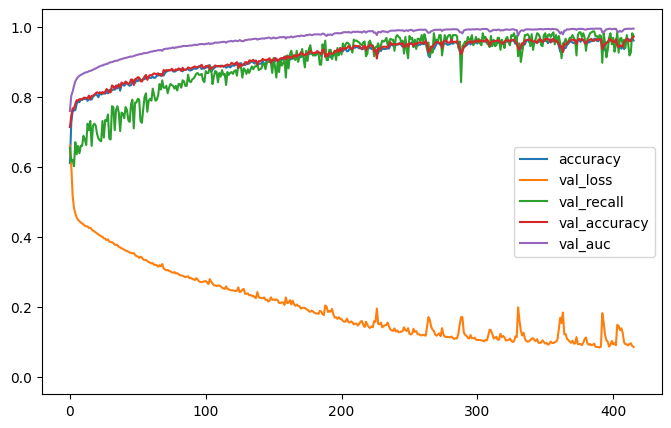

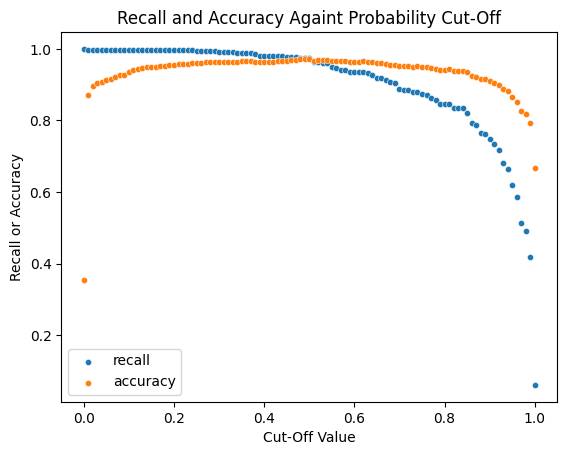

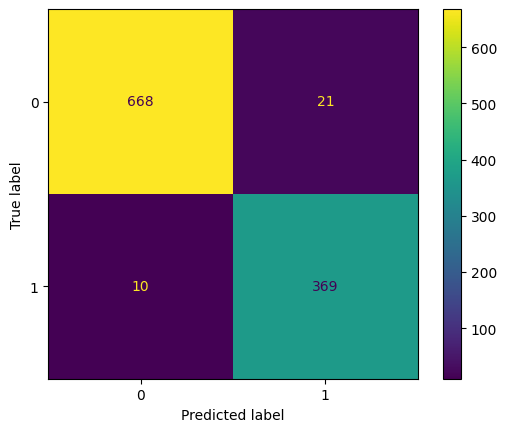

In [40]:
evaluate_model(model, history, X, y)

In [41]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 16)                144       
                                                                 
 dense_34 (Dense)            (None, 16)                272       
                                                                 
 dense_35 (Dense)            (None, 8)                 136       
                                                                 
 dense_36 (Dense)            (None, 8)                 72        
                                                                 
 dense_37 (Dense)            (None, 8)                 72        
                                                                 
 dense_38 (Dense)            (None, 8)                 72        
                                                                 
 dense_39 (Dense)            (None, 8)               

34/34 [==============================] - 0s 470us/step
Accuracy:  0.99
Specificity:  0.98
Recall:  1.0
F1 Score: 0.99


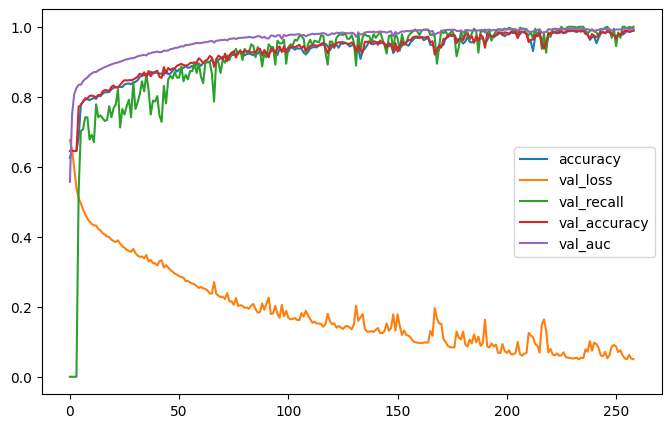

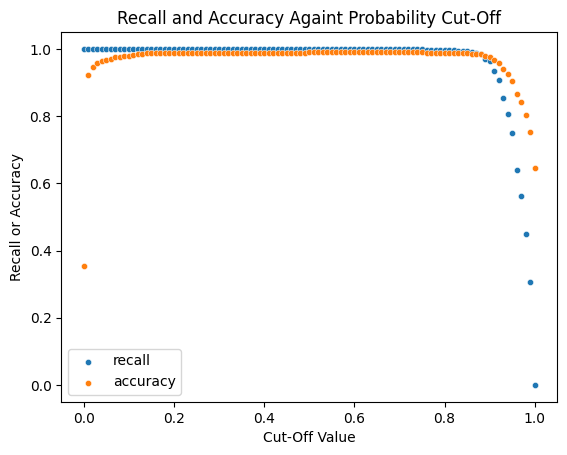

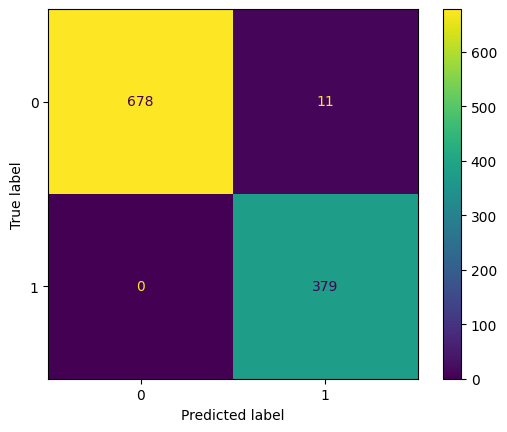

In [42]:
evaluate_model(model, history, X, y)

In [87]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 16)                144       
                                                                 
 dense_85 (Dense)            (None, 16)                272       
                                                                 
 dense_86 (Dense)            (None, 16)                272       
                                                                 
 dense_87 (Dense)            (None, 16)                272       
                                                                 
 dense_88 (Dense)            (None, 16)                272       
                                                                 
 dense_89 (Dense)            (None, 16)                272       
                                                                 
 dense_90 (Dense)            (None, 8)               

34/34 [==============================] - 0s 452us/step
Accuracy:  1.0
Specificity:  1.0
Recall:  1.0
F1 Score: 1.0


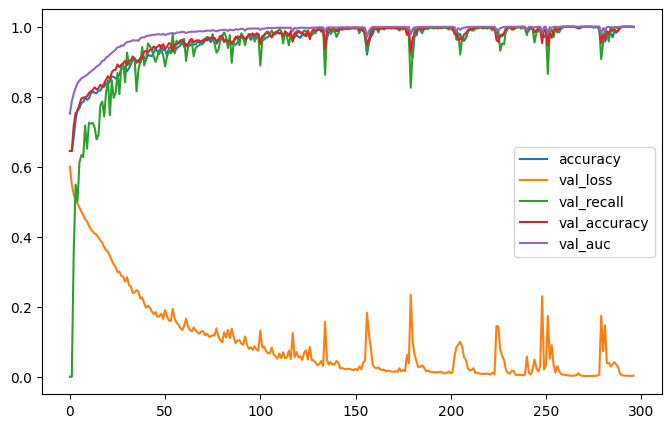

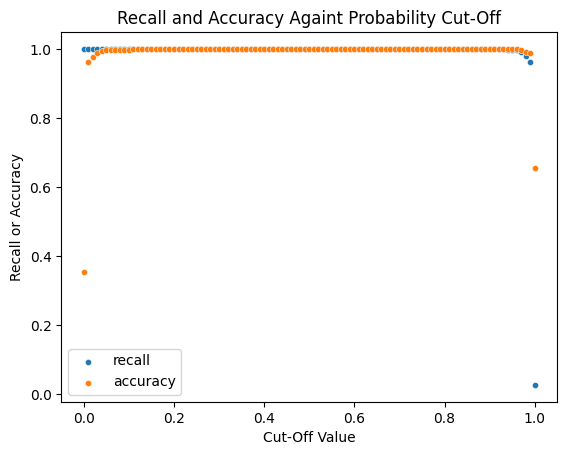

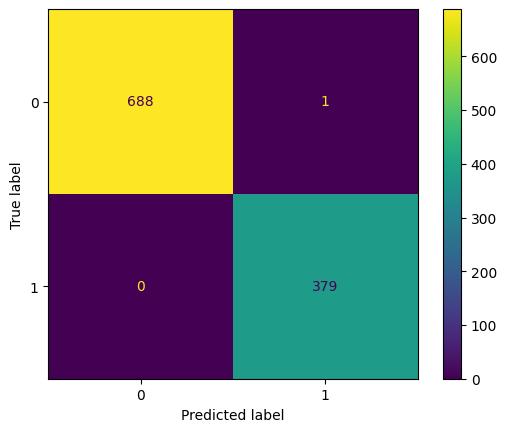

In [88]:
evaluate_model(model, history, X, y)

## Phase 3: Model Selection and Evaluation


The main goal in this phase is to obtain highest possible accuracy on the validation set after splitting your data into training set and validation set.  
* Please shuffle your rows before splitting.
* As your baseline model, i.e., the model with minimum accuracy, you can test the accuracy on the validation set using a ‘logistic regression’ model.
* Gradually grow your model into a multi-layered model and investigate if larger models deliver higher accuracy on the validation set.
    * As you explore various network architectures, please note the accuracies of these models to include in your report.
    * You can summarize your findings in the form of a table and the table should contain the accuracy and loss on the training set and the validation set (see below).
    * You can also include other parameters such as number of epochs, number of neurons, total number of parameters, etc.
 * Remember to select one model as your best performing model, i.e., the model that delivers highest accuracy on the validation set.
 * Your report should also include learning curves of your experiments.
 * You should also evaluate your models using other metrics besides precision; for example recall, precision, and F1 score.
 * Please note that your submission for this phase is ineligible for points if you do not use “model checkpointing” in your code.
 * You are discouraged to use external library methods such as “from sklearn.model_selection import train_test_split”.



[FOR GRADUATE STUDENTS ONLY] 

* discuss what architecture (how big) you do need to overfit when you have output as additional input feature,
* code a function that represents your model.
    * Once you have finished coding your model, please build your own function/method that serves as a prediction model.
    * Afterwards, please verify that predictions you obtain are same as the one you obtained using your trained model.

In [43]:
# shuffle rows
df = df.sample(frac=1)

In [44]:
df.shape

(1068, 9)

In [45]:
# split our data
df_train = df.iloc[:900, :]
df_test = df.iloc[900:, :]

In [46]:
X_train = df_train.drop(axis=1, labels='Outcome')
y_train = df_train['Outcome']
X_test = df_test.drop(axis=1, labels='Outcome')
y_test = df_test['Outcome']

In [47]:
# Create a transformer from the training data and use it to res-scale the training and test data

In [48]:
transform_dict = {}

for column in numeric_cols:
    transform_dict[column] = X_train[column].mean(), X_train[column].std()

In [49]:
transform_dict

{'Pregnancies': (3.901111111111111, 3.356497010122947),
 'Glucose': (120.88333333333334, 32.363424850834924),
 'BloodPressure': (68.95333333333333, 19.753487463313725),
 'SkinThickness': (20.227777777777778, 16.08999666971815),
 'Insulin': (77.71111111111111, 116.4760612588377),
 'BMI': (31.94411111111111, 8.107652957090844),
 'DiabetesPedigreeFunction': (0.46961888888888886, 0.3192167874245103),
 'Age': (33.04666666666667, 11.417452441097199)}

In [50]:
def data_norms_2(data, mean, std):  
    return (data - mean)/std

In [51]:
for column in numeric_cols:
    X_train[column] = data_norms_2(X_train[column], 
                                            transform_dict[column][0], 
                                            transform_dict[column][1])

In [52]:
for column in numeric_cols:
    X_test[column] = data_norms_2(X_test[column], 
                                            transform_dict[column][0], 
                                            transform_dict[column][1])

In [53]:
# Verify
X_train[numeric_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,900.0,-6.710681e-17,1.0,-1.162257,-0.864327,-0.268468,0.625321,3.902547
Glucose,900.0,-2.131628e-16,1.0,-3.735184,-0.676175,-0.119991,0.621586,2.413733
BloodPressure,900.0,1.578984e-17,1.0,-3.490692,-0.250757,0.154234,0.559226,2.685433
SkinThickness,900.0,-4.342206e-17,1.0,-1.257165,-1.257165,0.172295,0.731649,4.895726
Insulin,900.0,6.710681e-17,1.0,-0.667185,-0.667185,-0.667185,0.386679,6.596110
BMI,900.0,2.269789e-16,1.0,-3.939995,-0.563555,0.006893,0.598927,3.386416
DiabetesPedigreeFunction,900.0,9.079157e-17,1.0,-1.226812,-0.703656,-0.294843,0.503204,6.109895
Age,900.0,3.947460e-18,1.0,-1.055110,-0.792354,-0.354428,0.696594,4.200003


### Logistic Regression

In [54]:
formula = "Outcome ~"
for col in X_train.columns:
    formula += " + "
    formula += col
logit = smf.logit(formula, data=pd.concat([X_train, y_train], axis=1)).fit()

Optimization terminated successfully.
         Current function value: 0.474174
         Iterations 6


In [55]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  900
Model:                          Logit   Df Residuals:                      891
Method:                           MLE   Df Model:                            8
Date:                Sat, 27 Apr 2024   Pseudo R-squ.:                  0.2692
Time:                        20:02:21   Log-Likelihood:                -426.76
converged:                       True   LL-Null:                       -583.93
Covariance Type:            nonrobust   LLR p-value:                 3.627e-63
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.8712      0.090     -9.681      0.000      -1.048      -0.695
Pregnancies                  0.4593      0.102      4.491      0.000       0.259       0.

Accuracy:  0.83
Specificity:  0.94
Recall:  0.65
F1 Score: 0.74


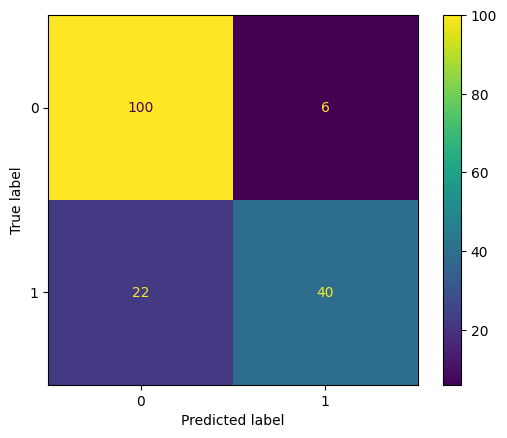

In [56]:
y_pred_logit = logit.predict(X_test)
y_pred_logit = (y_pred_logit >= 0.5)*1
scores(y_test, y_pred_logit)
conf_matrix = confusion_matrix(y_test, y_pred=y_pred_logit)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.show()

### MLPs

In [57]:
model = Sequential()
model.add(Dense(2, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 2)                 18        
                                                                 
 dense_43 (Dense)            (None, 1)                 3         
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 394: early stopping


6/6 [==============================] - 0s 627us/step
Accuracy:  0.77
Specificity:  0.86
Recall:  0.63
F1 Score: 0.67


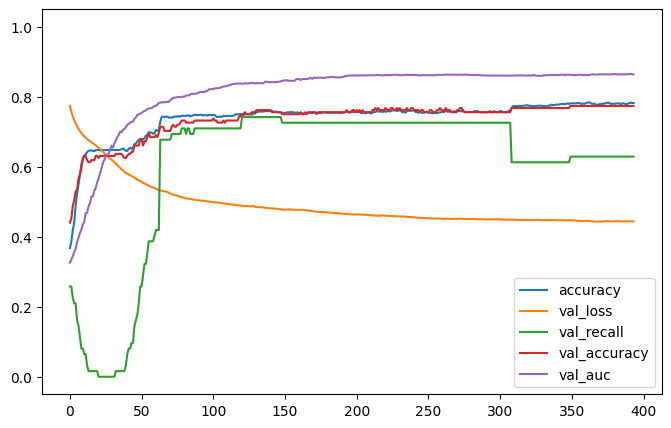

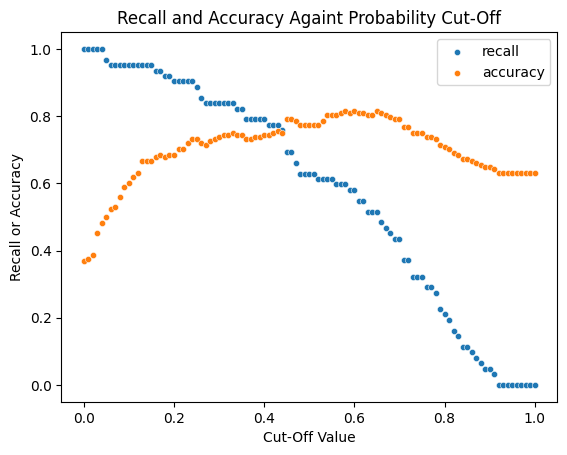

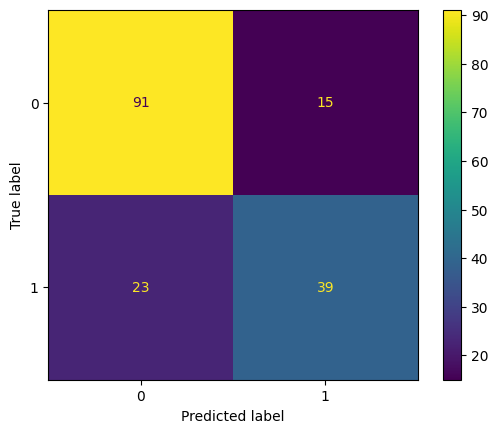

In [58]:
evaluate_model(model, history, X_test, y_test)

In [59]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 8)                 72        
                                                                 
 dense_45 (Dense)            (None, 1)                 9         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 168: early stopping


6/6 [==============================] - 0s 598us/step
Accuracy:  0.77
Specificity:  0.88
Recall:  0.6
F1 Score: 0.66


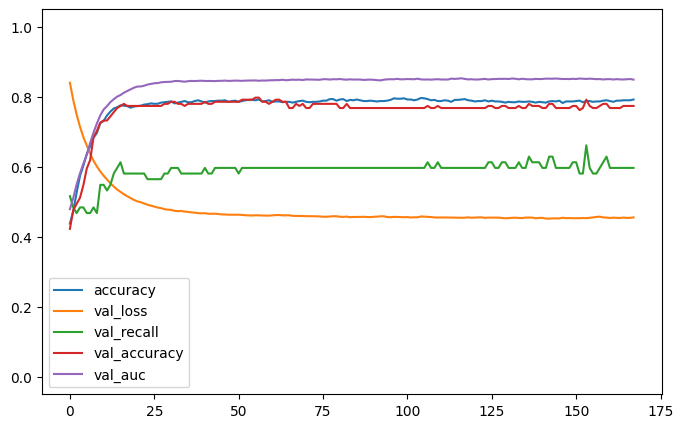

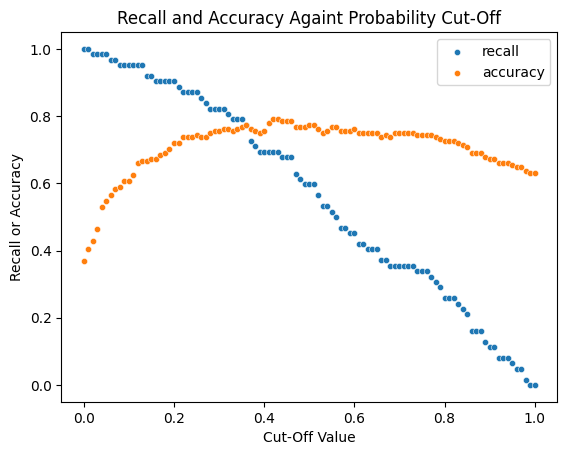

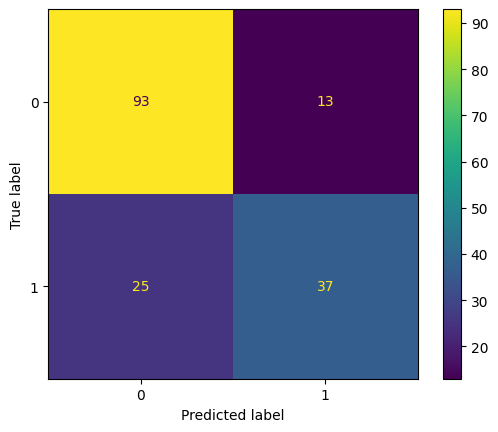

In [60]:
evaluate_model(model, history, X_test, y_test)

In [61]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 8)                 72        
                                                                 
 dense_47 (Dense)            (None, 8)                 72        
                                                                 
 dense_48 (Dense)            (None, 1)                 9         
                                                                 
Total params: 153 (612.00 Byte)
Trainable params: 153 (612.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 95: early stopping


6/6 [==============================] - 0s 560us/step
Accuracy:  0.76
Specificity:  0.81
Recall:  0.68
F1 Score: 0.68


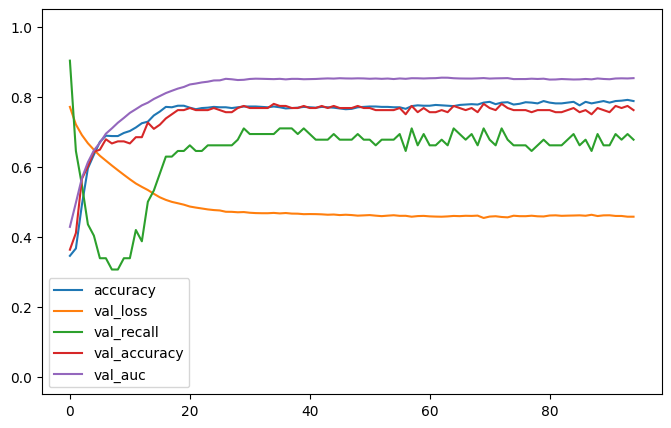

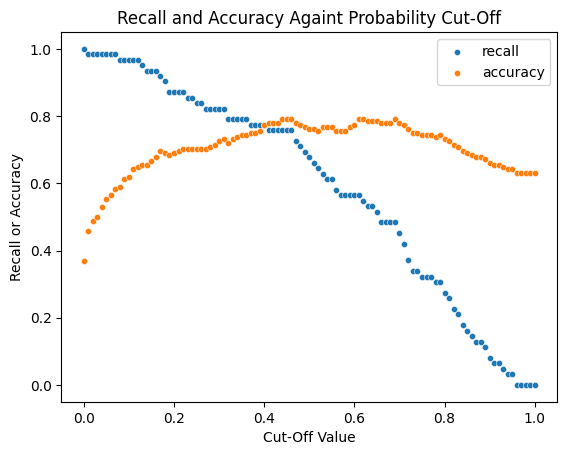

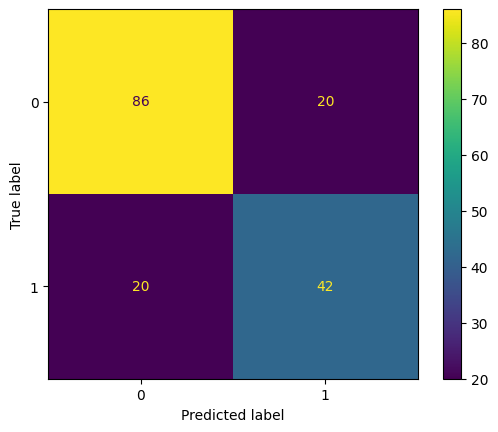

In [62]:
evaluate_model(model, history, X_test, y_test)

In [63]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 8)                 72        
                                                                 
 dense_50 (Dense)            (None, 16)                144       
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 233 (932.00 Byte)
Trainable params: 233 (932.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 163: early stopping


6/6 [==============================] - 0s 632us/step
Accuracy:  0.8
Specificity:  0.9
Recall:  0.63
F1 Score: 0.7


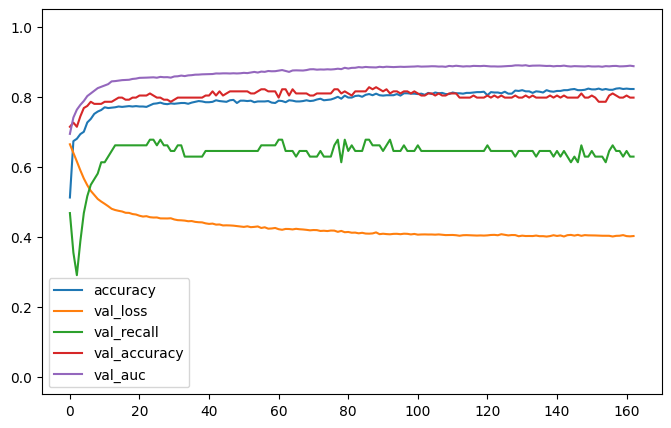

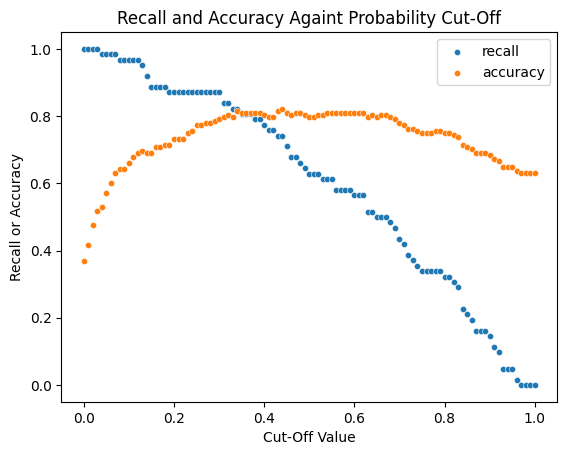

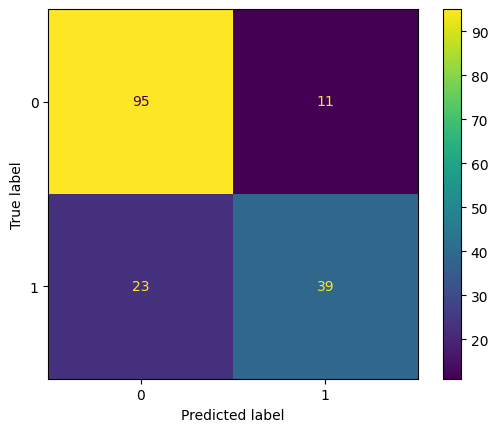

In [64]:
evaluate_model(model, history, X_test, y_test)

In [65]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 8)                 72        
                                                                 
 dense_53 (Dense)            (None, 8)                 72        
                                                                 
 dense_54 (Dense)            (None, 8)                 72        
                                                                 
 dense_55 (Dense)            (None, 8)                 72        
                                                                 
 dense_56 (Dense)            (None, 1)                 9         
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 216: early s

6/6 [==============================] - 0s 884us/step
Accuracy:  0.79
Specificity:  0.85
Recall:  0.68
F1 Score: 0.7


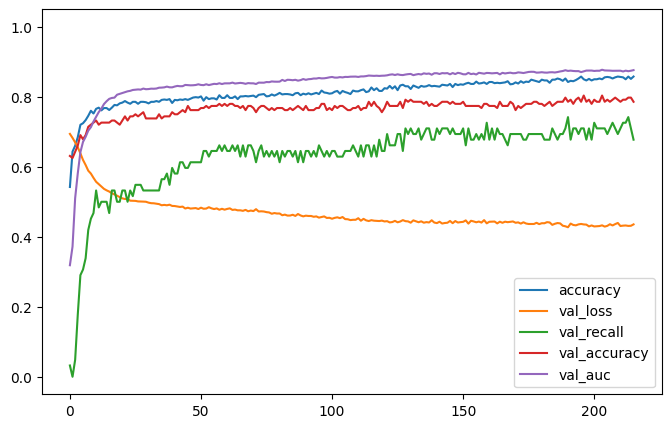

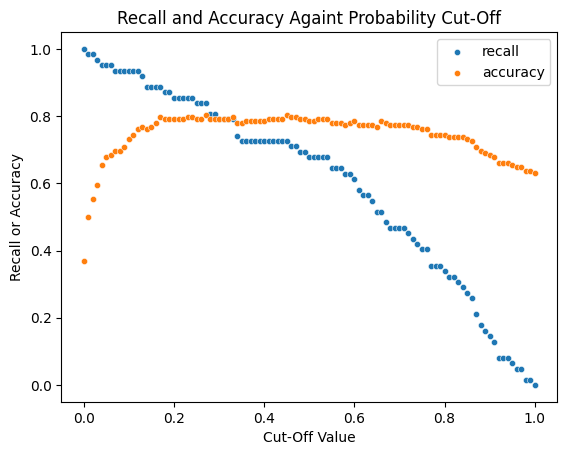

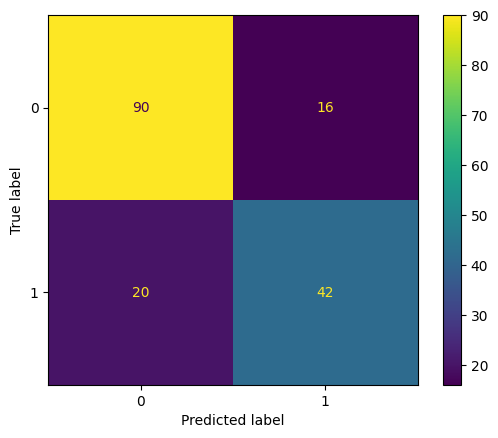

In [66]:
evaluate_model(model, history, X_test, y_test)

In [67]:
model_f = Sequential()
model_f.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model_f.add(Dense(8, activation='relu'))
model_f.add(Dense(8, activation='relu'))
model_f.add(Dense(8, activation='relu'))
model_f.add(Dense(1, activation='sigmoid'))
print(model_f.summary())
history = train_model(model_f, X_train, y_train, X_test, y_test)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 16)                144       
                                                                 
 dense_58 (Dense)            (None, 8)                 136       
                                                                 
 dense_59 (Dense)            (None, 8)                 72        
                                                                 
 dense_60 (Dense)            (None, 8)                 72        
                                                                 
 dense_61 (Dense)            (None, 1)                 9         
                                                                 
Total params: 433 (1.69 KB)
Trainable params: 433 (1.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 55: early st

6/6 [==============================] - 0s 1ms/step
Accuracy:  0.85
Specificity:  0.89
Recall:  0.79
F1 Score: 0.8


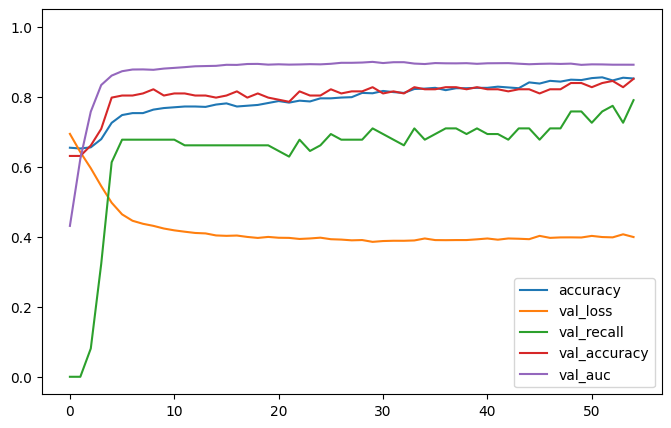

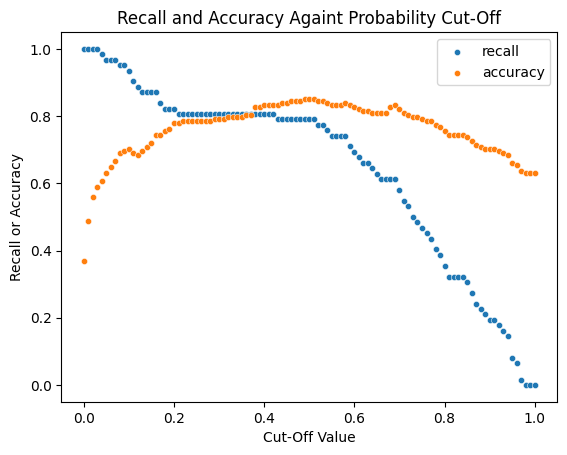

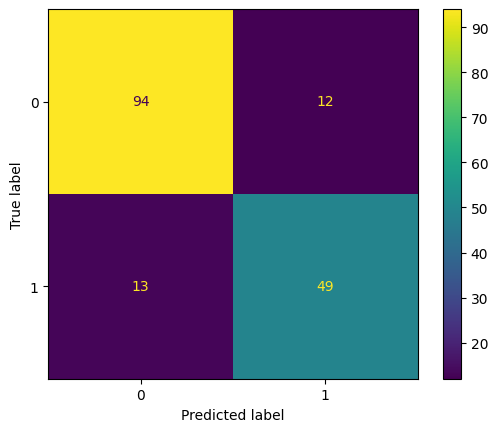

In [68]:
evaluate_model(model_f, history, X_test, y_test)

In [69]:
train_pred = model_f.predict(X_train)
test_pred = model_f.predict(X_test)

6/6 [==============================] - 0s 552us/step


(900, 1)

In [109]:
X_train_grad =X_train.copy()
X_train_grad["preds"] = train_pred

X_test_grad = X_test.copy()
X_test_grad["preds"] = test_pred

accs = []
Epoch = 1
Go = True


while Go:  
    model_g = Sequential()
    model_g.add(Dense(9, input_dim = X_train_grad.shape[1], activation='relu'))
    model_g.add(Dense(2, activation='relu'))
    model_g.add(Dense(1, activation='sigmoid'))
    history = train_model(model_g, X_train_grad, y_train, X_train_grad, y_train)
    X_train_grad["preds"] = model_g.predict(X_train_grad)
    X_test_grad["preds"] = model_g.predict(X_test_grad)
    
    _acc = accuracy_score(y_train, (X_train_grad["preds"]>0.5)*1)
    accs.append(_acc)
    print(f"Epoch {Epoch}: {_acc: 0.4f}")   
    if _acc > 0.999:
        Go = False
    Epoch += 1

6/6 [==============================] - 0s 505us/step
Epoch 1:  0.8833
6/6 [==============================] - 0s 547us/step
Epoch 2:  0.9067
6/6 [==============================] - 0s 581us/step
Epoch 3:  0.9189
6/6 [==============================] - 0s 704us/step
Epoch 4:  0.9256
6/6 [==============================] - 0s 574us/step
Epoch 5:  0.9322
6/6 [==============================] - 0s 539us/step
Epoch 6:  0.9344
6/6 [==============================] - 0s 611us/step
Epoch 7:  0.9556
6/6 [==============================] - 0s 563us/step
Epoch 8:  0.9656
6/6 [==============================] - 0s 552us/step
Epoch 9:  0.9689
6/6 [==============================] - 0s 646us/step
Epoch 10:  0.9778
6/6 [==============================] - 0s 526us/step
Epoch 11:  0.9878
6/6 [==============================] - 0s 500us/step
Epoch 12:  0.9922


6/6 [==============================] - 0s 908us/step
Accuracy:  0.87
Specificity:  0.93
Recall:  0.76
F1 Score: 0.81


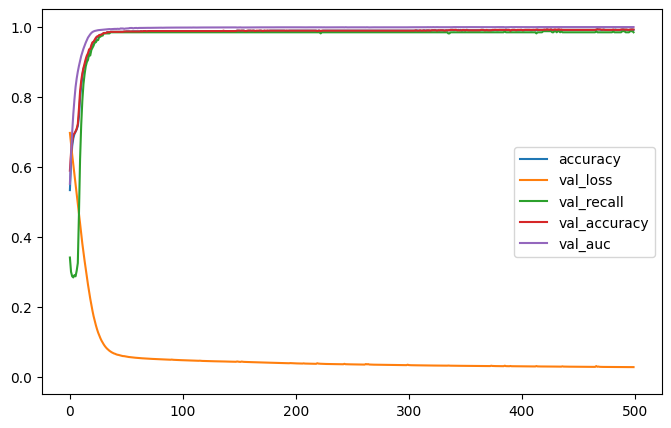

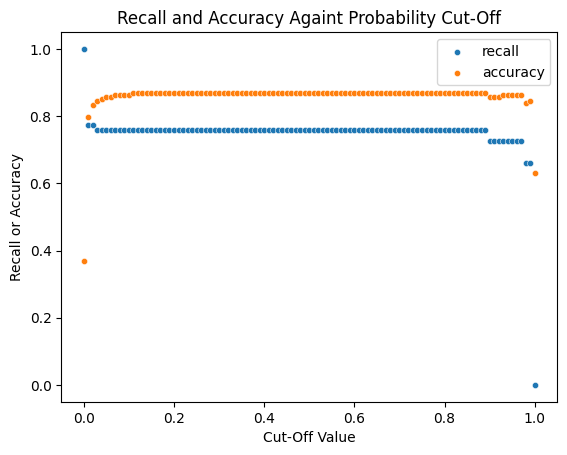

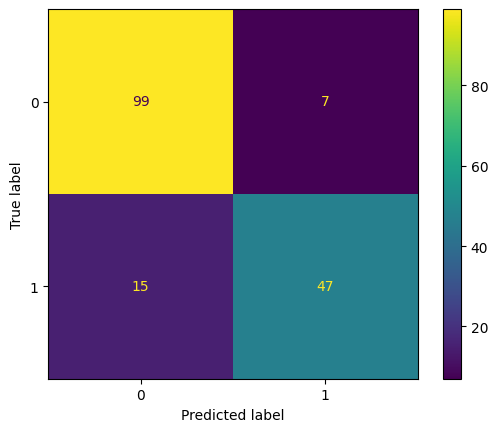

In [110]:
evaluate_model(model_g, history, X_test_grad, y_test)

In [72]:

model_g.add(Dense(8, activation='relu'))
model_g.add(Dense(8, activation='relu'))
model_g.add(Dense(8, activation='relu'))
model_g.add(Dense(1, activation='sigmoid'))
print(model_g.summary())
history = train_model(model_g, X_train_grad, y_train, X_test_grad, y_test)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 16)                160       
                                                                 
 dense_63 (Dense)            (None, 8)                 136       
                                                                 
 dense_64 (Dense)            (None, 8)                 72        
                                                                 
 dense_65 (Dense)            (None, 8)                 72        
                                                                 
 dense_66 (Dense)            (None, 1)                 9         
                                                                 
Total params: 449 (1.75 KB)
Trainable params: 449 (1.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 48: early st

6/6 [==============================] - 0s 583us/step
Accuracy:  0.83
Specificity:  0.88
Recall:  0.74
F1 Score: 0.76


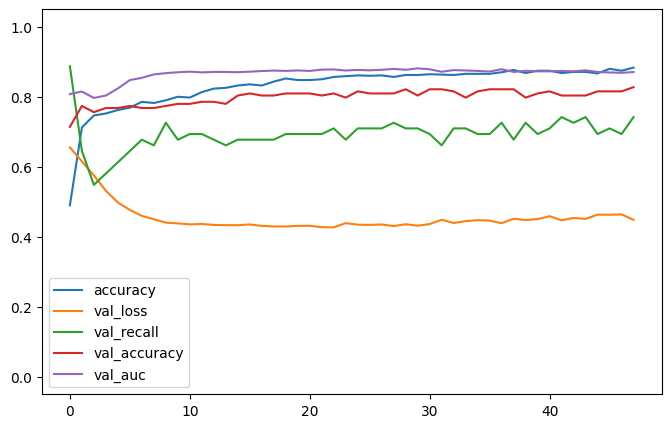

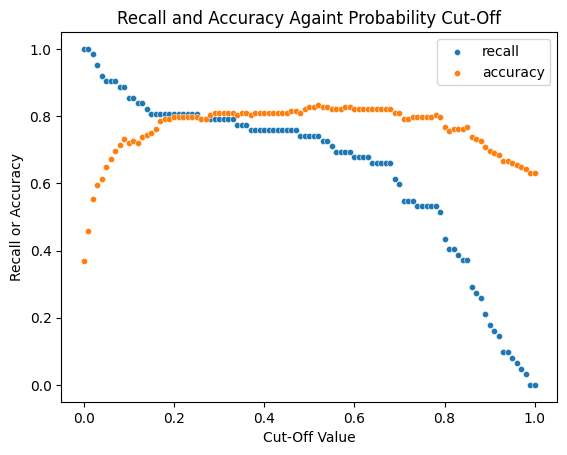

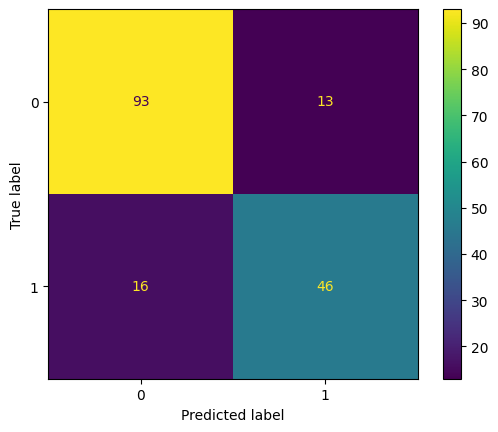

In [73]:
evaluate_model(model_g, history, X_test_grad, y_test)

## Phase 4: Feature Importance and Reduction  
The key activity in this phase is to study the importance of the input features by iteratively removing them. You must continue to use model checkpointing in this phase. Here are the steps involved:

* If you have 10 input features/columns, train 10 models where each model only receives one feature at a time.
    * For example, if age, BMI, and blood pressure are your only three input features, you train three models: one that only take age as input, another that only takes BMI as the input, and the last one that takes only blood pressure as the input.
    * The validation accuracy of these three models will indicate the relative importance of the three features.
    * You should plot these validation accuracies in the form of a bar diagram. If all your accuracies are more than 80%, your plot’s y-axis should be limited to 80-100.
* From the previous step you have the significance/important of each feature. The feature that yields the highest accuray is the most important feature.
    * Starting with the most unimportant feature, remove one feature at a time (without replacement) and train various models.
    * You can iteratively repeat the process removing more and more unimportant features. For example, if BMI is the most important feature and blood pressure is the least important one, you would train two models: one without blood pressure, and one without blood pressure and age.
    * Plot the validation dataset accuracy of all the models that you tested. The overall objective is to identify non-informative input features and remove them from the dataset.
* Finally, you can compare your feature-reduced model with the original model with all input features and discuss the difference in accuracy. 

For bonus points: Use model-agnostic methods such as LIME or Shapley values to derive feature importance. 
 
 https://christophm.github.io/interpretable-ml-book/

In [74]:
def create_model():
    model = Sequential()
    model.add(Dense(1, input_dim=1, activation='sigmoid'))
    return model

In [75]:
feature_models = []
for i in range(X_train.shape[1]):
    feature_models.append((create_model(), X_train.iloc[:, i], y_train,  X_test.iloc[:, i], y_test))

In [76]:
from funcs import mp_train

In [77]:
pool = multiprocessing.Pool()
history = pool.starmap(mp_train, feature_models)
pool.close()
pool.join()

In [78]:
def f_acc(idx, model_list, _X, _y):
    _preds = model_list[idx][0].predict(_X.iloc[:,idx])
    _y_preds_01 = (_preds >= 0.5)*1
    return accuracy_score(_y_preds_01, _y)

In [79]:
feature_scores = {}
cols = X_train.columns
for i in range(X_train.shape[1]):
    feature_scores[cols[i]] = f_acc(i, feature_models, X_test, y_test)

6/6 [==============================] - 0s 580us/step


In [80]:
feature_scores = dict(sorted(feature_scores.items(), key=lambda item: item[1]))

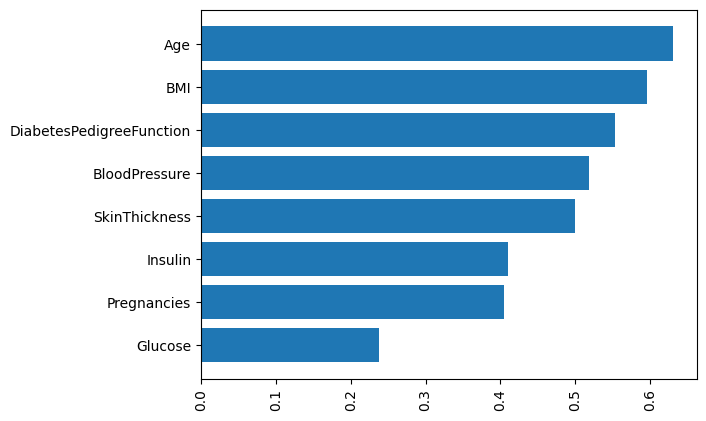

In [81]:
plt.barh(*zip(*feature_scores.items()))
plt.xticks(rotation=90)
plt.show()

In [82]:
# https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test, silent=True)

28/28 [==============================] - 0s 388us/step


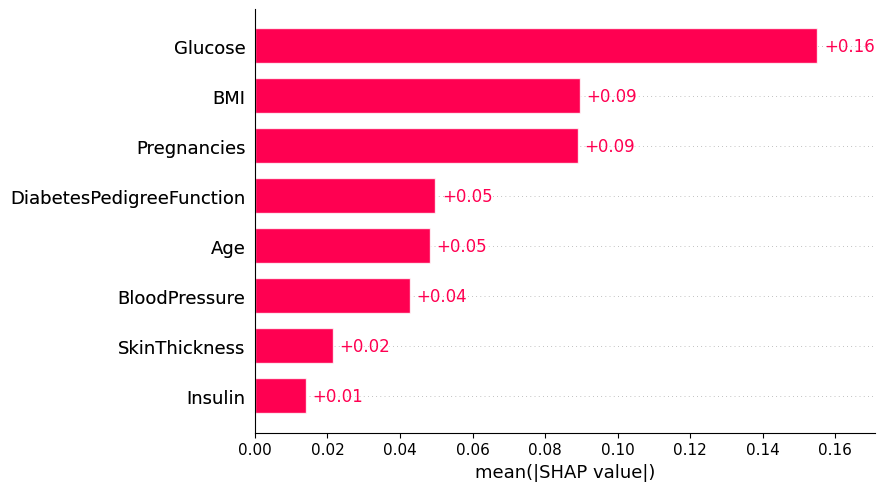

In [83]:
shap.plots.bar(shap_values)

## Phase 5: Final Report  

* Please submit a PDF of your final report.
* 10/12 pages at most.
* Should include abstract and conclusion (each 250 words minimum).
* It should contain the important findings in each phase of your project.
* Your final/best model should be evaulated using ROC and AUC
* Your report should NOT include the results of your Phase II.
* Your tables and figures should be numbered and captioned (labelled) appropriately.
* Submit a link to your final Notebook. Optionally, you are welcome to host your project (and report) at Github (i.e., no extra points for hosting). .

In [ ]:
A = sum([50, 54, 42, 35, 50, 43, 85])
A_d = sum([50, 55, 60, 45, 50, 43, 85])
MT = 85/90
Lead = .9
Revies = 1
Present = 1
Milestones = 1

In [ ]:
85/90